# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

## Define Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


## Define Folder Output

In [4]:
os.makedirs("./output", exist_ok=True)

## Data Visualization

In [5]:
df = pd.read_csv('./dataset/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [6]:
df.shape

(27643, 3)

In [7]:
unique, counts = np.unique(df['Popularity'].values, return_counts=True)
dict(zip(unique, counts))

{-1: 14011, 1: 13632}

In [8]:
def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace ('-', '') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    return text

print('Before:', df.iloc[0]['Page content'])
processed_txt = preprocessor(df.iloc[0]['Page content'])
print('After:', processed_txt)

Before: <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks and figure o

Check what the data looks like

In [9]:
with open("./output/out.txt",'w') as f:
    print(BeautifulSoup(df.iloc[0]['Page content'], 'html.parser').prettify(), file=f)

In [10]:
with open("./output/out2.txt",'w') as f:
    print(BeautifulSoup(df.iloc[1]['Page content'], 'html.parser').prettify(), file=f)

In [11]:
with open("./output/out3.txt",'w') as f:
    print(BeautifulSoup(df.iloc[300]['Page content'], 'html.parser').prettify(), file=f)

# Preprocess Data

## Split X and y data

In [12]:
X = df['Page content'].values[:, np.newaxis]
y = df['Popularity'].values[:, np.newaxis]
X.shape, y.shape

((27643, 1), (27643, 1))

## Scale y data from [-1, 1] to [0, 1]
Useful for logistic regression model since y has to be [0, 1]

In [13]:
min, max = 0, 1
y_std = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))
y = y_scaled = y_std * (max - min) + min
y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

## Feature Extraction from X 

### Check the tags in all the data

#### Get Title from Data

In [14]:
titles = []

for x_data in X:
    soup = BeautifulSoup(x_data[0], 'html.parser')
    # print(soup.title)
    title = soup.find_all(attrs={"class": "title"})
    # print(title[0].get_text)
    if title is not None:
        titles.append(title[0].get_text())
    else:
        titles.append(np.nan)

titles = np.array(titles)[:, np.newaxis]
print(titles.shape)

(27643, 1)


#### Get Category from Data

In [15]:
categories_extracted = []
for x_data in X:
    categories = []
    soup = BeautifulSoup(x_data[0], 'html.parser')
    # print(soup.title)
    html_cats = soup.find_all(attrs={"href": re.compile(r'/category/')})

    for cat in html_cats:
        # print(cat.get('href'))
        categories.append(cat.get_text())

    category_str = ""
    if len(categories) != 0:
        category_str = " ".join(categories) 
    else:
        category_str = np.nan

    categories_extracted.append(category_str)

categories_extracted = np.array(categories_extracted)[:, np.newaxis]
print(categories_extracted.shape)

(27643, 1)


In [16]:
print(categories_extracted[254])

['Reddit internet memes Memes photobombs Photography reddit Watercooler']


#### Get Time from Data

In [17]:
dates = []
days = []
for x_data in X:
    soup = BeautifulSoup(x_data[0], 'html.parser')
    # print(soup.title)
    # find only the date when it is written
    html_date = soup.find("time")

    if html_date is not None:
        # print(cat.get('href'))
        # ex of pattern : Wed, 19 Jun 2013 15:04:30 +0000
        days.append(html_date.get('datetime').replace(',', ' ')[0:3])
        dates.append(html_date.get_text())
    else:
        days.append(np.nan)
        dates.append(np.nan)

print(days)
print(dates)

['Wed', 'Thu', 'Wed', 'Fri', 'Thu', 'Thu', 'Mon', 'Thu', 'Mon', 'Thu', 'Mon', 'Tue', 'Thu', 'Thu', 'Sat', 'Mon', 'Fri', 'Fri', 'Sat', 'Thu', 'Tue', 'Thu', 'Sun', 'Tue', 'Wed', 'Sun', 'Sun', 'Wed', 'Wed', 'Fri', 'Tue', 'Thu', 'Wed', 'Wed', 'Tue', 'Thu', 'Sun', 'Mon', 'Tue', 'Wed', 'Sun', 'Wed', 'Fri', 'Thu', 'Tue', 'Mon', 'Mon', 'Thu', 'Wed', 'Wed', 'Tue', 'Mon', 'Tue', 'Mon', 'Tue', 'Mon', 'Fri', 'Sun', 'Tue', 'Fri', 'Thu', 'Thu', 'Thu', 'Thu', 'Tue', 'Wed', 'Thu', 'Tue', 'Mon', 'Wed', 'Mon', 'Wed', 'Fri', 'Fri', 'Sat', 'Sun', 'Wed', 'Wed', 'Wed', 'Wed', 'Tue', 'Tue', 'Thu', 'Thu', 'Wed', 'Mon', 'Thu', 'Fri', 'Mon', 'Wed', 'Wed', 'Mon', 'Thu', 'Wed', 'Fri', 'Thu', 'Fri', 'Thu', 'Fri', 'Thu', 'Thu', 'Mon', 'Wed', 'Thu', 'Thu', 'Fri', 'Sun', 'Fri', 'Wed', 'Tue', 'Wed', 'Thu', 'Thu', 'Thu', 'Wed', 'Wed', 'Fri', 'Fri', 'Thu', 'Mon', 'Wed', 'Tue', 'Thu', 'Tue', 'Sun', 'Wed', 'Tue', 'Wed', 'Wed', 'Mon', 'Tue', 'Wed', 'Wed', 'Thu', 'Wed', 'Fri', 'Wed', 'Thu', 'Wed', 'Tue', 'Wed', 'Thu', 'Wed'

In [18]:
# Parse date and time
from datetime import datetime
from dateutil import parser
import pytz

def date_week_parser(day):
    dict_days = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6}
    return dict_days[day]

def date_parser(time):
    timestamp = parser.parse(time)
    # Also convert everything to UTC
    timestamp = timestamp.astimezone(pytz.UTC)
    return timestamp

def get_year(dt):
    # Extract individual components
    return dt.year

def get_month(dt):
    return dt.month

def get_date_day(dt):
    return dt.day

def get_time_second(dt):
    hour = dt.hour
    minute = dt.minute
    second = dt.second
    return hour * 3600 + minute * 60 + second
        
print('before', dates[456])
dt = date_parser(dates[456])
print(dt)

before 2014-11-22 12:08:03 UTC
2014-11-22 12:08:03+00:00


In [19]:
get_time_second(dt)

43683

##### Execute time and date features

In [20]:
features_day = []
for day in days:
    feature_day = date_week_parser(day) 
    features_day.append(feature_day)

features_yr = []
features_time = []
features_month = []
features_date = []

for date in dates:
    dt = date_parser(date)
    yr = get_year(dt)
    time = get_time_second(dt)
    month = get_month(dt)
    date_day = get_date_day(dt)

    features_yr.append(yr)
    features_time.append(time)
    features_month.append(month)
    features_date.append(date_day)

features_day = np.array(features_day)[:, np.newaxis]
features_yr = np.array(features_yr)[:, np.newaxis]
features_time = np.array(features_time)[:, np.newaxis]
features_month = np.array(features_month)[:, np.newaxis]
features_date = np.array(features_date)[:, np.newaxis]
print(features_day.shape)
print(features_date.shape)

(27643, 1)
(27643, 1)


#### Combine Data Together into an np.array

In [21]:
concatenated_features = np.concatenate((titles, categories_extracted, features_day, features_yr, features_time, features_month, features_date), axis=1)
concatenated_features.shape

(27643, 7)

## Tokenizer

In [22]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/audreych/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Combine Feature Extracted into a new dataframe

In [23]:
print(df.head())

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [24]:
old_features_name = [c for c in df.columns]
new_features_name = ['Id', 'Popularity', 'Title', 'Category', 'Day', 'Year', 'Time', 'Month', 'Date']
# new_features_name = [c for c in df.columns]
print(old_features_name)

['Id', 'Popularity', 'Page content']


### Add new column feature in the dataframe
Given column name and also the data to be added

In [25]:
def add_new_features_df(df, new_feature_name, new_data):
    if (len(new_data.shape) == 2 and new_data.shape[1] != 1) or (len(new_data.shape) > 2):
        print('Check dimension again, it should be 2 dimension and (sample, 1) or (sample, )')
        return
    elif len(new_data.shape) == 2 and new_data.shape[1] == 1:
        new_data = new_data.reshape(-1)
    
    new_data = np.array(new_data)
    if new_feature_name not in df.columns:
        df[new_feature_name] = new_data.tolist()

dummy = np.zeros((df.shape[0], 1))
new_df = df.copy()
add_new_features_df(new_df, 'dummy', dummy)
print(new_df.head())

   Id  Popularity                                       Page content  dummy
0   0          -1  <html><head><div class="article-info"> <span c...    0.0
1   1           1  <html><head><div class="article-info"><span cl...    0.0
2   2           1  <html><head><div class="article-info"><span cl...    0.0
3   3          -1  <html><head><div class="article-info"><span cl...    0.0
4   4          -1  <html><head><div class="article-info"><span cl...    0.0


### Utility Function for Deleting Column in DataFrame
delete columns given columns name

In [26]:
def delete_features_df(df, feature_name):
    if feature_name in df.columns:
        df.drop(columns=feature_name, inplace=True)
    
delete_features_df(new_df, 'dummy')
print(new_df.head())

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Execute and Get New Dataframe

In [27]:
new_df = df.copy()
new_feat_not_in_old_df = [item for item in new_features_name if item not in old_features_name]

for (feature_name, extracted_data) in zip(new_feat_not_in_old_df, np.transpose(concatenated_features)):
    add_new_features_df(new_df, feature_name, extracted_data)

# print(new_df.head())
old_feat_not_in_new_df = [item for item in old_features_name if item not in new_features_name]

for feature_name in old_feat_not_in_new_df:
    delete_features_df(new_df, feature_name)
print(new_df.head())

   Id  Popularity                                              Title  \
0   0          -1  NASA's Grand Challenge: Stop Asteroids From De...   
1   1           1  Google's New Open Source Patent Pledge: We Won...   
2   2           1  Ballin': 2014 NFL Draft Picks Get to Choose Th...   
3   3          -1        Cameraperson Fails Deliver Slapstick Laughs   
4   4          -1  NFL Star Helps Young Fan Prove Friendship With...   

                                            Category Day  Year   Time Month  \
0  Asteroid Asteroids challenge Earth Space U.S. ...   3  2013  54270     6   
1  patent-lawsuit theater Apps and Software Googl...   4  2013  63655     3   
2  NFL ESPN Entertainment NFL NFL Draft Sports Te...   3  2014  69320     5   
3            YouTube Sports Video Videos Watercooler   5  2013   8810    10   
4  NFL Instagram Entertainment instagram instagra...   4  2014  12703     4   

  Date  
0   19  
1   28  
2    7  
3   11  
4   17  


## Tf-idf to Vectorize String (category)

TODO : don't leak the training data to fit the category

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1),
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(new_df['Category'])

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

doc_tfidf = tfidf.transform(new_df['Category']).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
world: 2.38
tech: 2.60
entertain: 2.68
watercool: 2.70
busi: 2.79
u.s.: 2.85
video: 2.94
app: 3.02
softwar: 3.07
mobil: 3.10

[vocabularies with highest tf-idf scores]
video: 1486.829647871692
world: 1181.2324028860792
busi: 948.2557152259608
watercool: 821.6963335747016
tech: 809.5107894182993
entertain: 808.2614402177
app: 787.4768746275479
u.s.: 784.4751157140291
twitter: 628.188871776262
media: 610.0546357328043


In [29]:
print(doc_tfidf.shape)

(27643, 9965)


### Use PCA to reduce dimension of Category
This is to make dimension smaller, since we still need to tf-idf title

In [30]:
from sklearn.preprocessing import StandardScaler # scikit-learn 1.3.1
# Z-normalize data
sc = StandardScaler()
Z = sc.fit_transform(doc_tfidf)

from sklearn.decomposition import PCA

In [31]:
R.shape

array([[ 1.00000000e+00, -6.13968528e-05, -5.10752479e-05, ...,
        -3.61768324e-05, -1.96978401e-04, -3.61768324e-05],
       [-6.13968528e-05,  1.00000000e+00, -8.66814276e-05, ...,
        -6.13968528e-05, -3.34298309e-04, -6.13968528e-05],
       [-5.10752479e-05, -8.66814276e-05,  1.00000000e+00, ...,
        -5.10752479e-05, -2.78098440e-04, -5.10752479e-05],
       ...,
       [-3.61768324e-05, -6.13968528e-05, -5.10752479e-05, ...,
         1.00000000e+00, -1.96978401e-04, -3.61768324e-05],
       [-1.96978401e-04, -3.34298309e-04, -2.78098440e-04, ...,
        -1.96978401e-04,  1.00000000e+00, -1.96978401e-04],
       [-3.61768324e-05, -6.13968528e-05, -5.10752479e-05, ...,
        -3.61768324e-05, -1.96978401e-04,  1.00000000e+00]])

Calculate Eigen values

In [32]:
eigen_vals, eigen_vecs = np.linalg.eigh(R)

print('\nEigenvalues: \n%s' % eigen_vals)


Eigenvalues: 
[-2.30106040e-14 -2.07788936e-14 -1.99318234e-14 ...  6.69622447e+00
  7.08587122e+00  1.08831942e+01]


In [35]:
print(eigen_vals.shape)

(9965,)


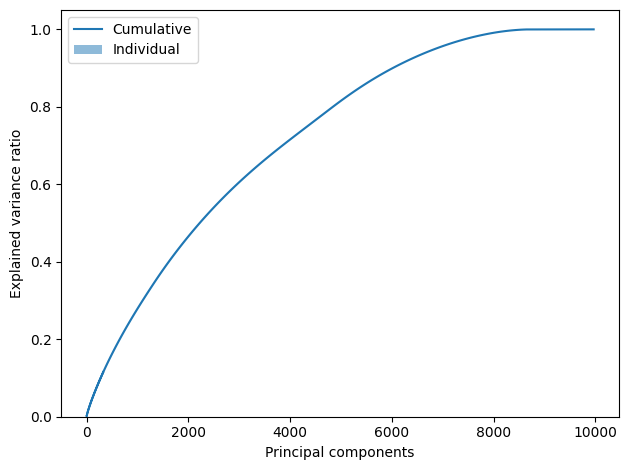

In [38]:
tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./output/fig-pca-var-exp.png', dpi=300)
plt.show()

In [42]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

9965


In [46]:
# Take more than 2
dimension_taken = 4800
arrays_list = [eig_pairs[1][:, np.newaxis]for eig_pairs in eigen_pairs[:dimension_taken]]
print(len(arrays_list))
W = np.hstack(arrays_list)
print(W.shape)

4800
(9965, 4800)


In [47]:
Z_pca = Z.dot(W)

In [48]:
Z_pca.shape

(27643, 4800)

### Save the Compressed Category

In [51]:
np.save('./output/Z_pca_cat.npy', Z_pca)
import _pickle as pkl

# dump to disk
pkl.dump(doc_tfidf, open('./output/doc_tfidf_cat.pkl', 'wb'))
pkl.dump(Z_pca, open('./output/doc_tfidf_pca.pkl', 'wb'))

## Tf-idf to Vectorize String (Title)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1),
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(new_df['Title'])

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

doc_tfidf = tfidf.transform(new_df['Category']).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
new: 3.92
app: 4.47
googl: 4.49
video: 4.54
twitter: 4.68
facebook: 4.69
get: 4.71
make: 4.79
appl: 4.81
first: 4.83

[vocabularies with highest tf-idf scores]
world: 1986.7153996181132
entertain: 1919.6037415677574
video: 1806.909805711871
busi: 1603.3949357367433
tech: 1363.7111294439055
softwar: 1135.806486590285
u.s.: 1132.5769736224327
app: 892.0499543534868
televis: 889.3719087324167
mobil: 871.4110939563049


In [53]:
print(doc_tfidf.shape)

(27643, 21753)


### Use PCA to reduce dimension of Title

In [54]:
# Z-normalize data
sc = StandardScaler()
Z = sc.fit_transform(doc_tfidf)
# Estimate the correlation matrix
R = np.dot(Z.T, Z) / df.shape[0]

In [55]:
eigen_vals, eigen_vecs = np.linalg.eigh(R)

print('\nEigenvalues: \n%s' % eigen_vals)

In [ ]:
tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./output/fig-pca-var-exp.png', dpi=300)
plt.show()

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [33]:

# do bow ///init
# PCA category
# tfidf title 
# PCA
# make model
# train it
# maybe chuking if no memory